In [1]:
import pymysql
import pandas as pd

ENDPOINT = 'heicoders-playground.c2ced10ceyki.ap-southeast-1.rds.amazonaws.com'
PORT = 3306
USERNAME = 'student300'
DBNAME = 'ai300_capstone'
PASSWORD = 'heicoders_AI300'   # Default password is empty. Do change this if you had previously set a password.
CURSORCLASS = pymysql.cursors.DictCursor

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Define function to establish MySQL database (local) connection
def initiate_local_connection():
    try:
        connection = pymysql.connect(host=ENDPOINT,
                                     port=PORT,
                                     user=USERNAME,
                                     passwd=PASSWORD,
                                     db=DBNAME,
                                     cursorclass=CURSORCLASS)
        print('[+] Local Connection Successful')
    except Exception as e:
        print(f'[+] Local Connection Failed: {e}')
        connection = None

    return connection

In [4]:
# Call function and return the connection object
connection = initiate_local_connection()

[+] Local Connection Successful


In [5]:
# Define SQL query, each line corresponds to the different tables in the database
sql_query_combined = '''
    SELECT *
    FROM customer AS c
    INNER JOIN account AS a ON c.customer_id = a.customer_id
    INNER JOIN account_usage AS au ON a.account_id = au.account_id
    LEFT JOIN city AS ct ON c.zip_code = ct.zip_code
    INNER JOIN churn_status AS cs ON c.customer_id = cs.customer_id;
'''

def get_combined_records(sql_query_combined):
    try:
        with connection.cursor() as cursor:
            cursor.execute(sql_query_combined)

        # Connection is not autocommit by default, so we must commit to save changes
        connection.commit()

        # Fetch all the records from SQL query output
        results = cursor.fetchall()

        # Convert results into pandas dataframe
        df = pd.DataFrame(results)

        print(f'Successfully retrieved records')

        return df

    except Exception as e:
        print(f'Error encountered: {e}')
    

In [6]:
# dumping the extracted data into the relevant data frames
combined3_df = get_combined_records(sql_query_combined)

Successfully retrieved records


In [7]:
#creating train_df, the file with all the info from all the different tables combined
combined3_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 44 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   customer_id                    7043 non-null   object 
 1   gender                         7043 non-null   object 
 2   age                            7043 non-null   int64  
 3   senior_citizen                 7043 non-null   object 
 4   married                        7043 non-null   object 
 5   num_dependents                 7043 non-null   int64  
 6   zip_code                       7043 non-null   int64  
 7   account_id                     7043 non-null   object 
 8   a.customer_id                  7043 non-null   object 
 9   tenure_months                  7043 non-null   int64  
 10  num_referrals                  7043 non-null   int64  
 11  has_internet_service           7043 non-null   object 
 12  internet_type                  7043 non-null   o

In [8]:
#checking to see if there is any missing value

# Check for missing values in each column
missing_values = combined3_df.isnull().any()

# Print columns with missing values (if any)
columns_with_missing_values = missing_values[missing_values]
if not columns_with_missing_values.empty:
    print("Columns with missing values:")
    print(columns_with_missing_values.index.tolist())
else:
    print("No columns have missing values.")

No columns have missing values.


In [9]:
#do this to remove all the entries without a churn_label = yes or no, it belongs to deceased person, which by right shouldnt be taken into consideration

# Filter rows where 'churn_label' is either "Yes" or "No"
train_df = combined3_df[combined3_df['churn_label'].isin(['Yes', 'No'])]

# Reset the index if needed
train_df.reset_index(drop=True, inplace=True)

# Display the filtered DataFrame
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6991 entries, 0 to 6990
Data columns (total 44 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   customer_id                    6991 non-null   object 
 1   gender                         6991 non-null   object 
 2   age                            6991 non-null   int64  
 3   senior_citizen                 6991 non-null   object 
 4   married                        6991 non-null   object 
 5   num_dependents                 6991 non-null   int64  
 6   zip_code                       6991 non-null   int64  
 7   account_id                     6991 non-null   object 
 8   a.customer_id                  6991 non-null   object 
 9   tenure_months                  6991 non-null   int64  
 10  num_referrals                  6991 non-null   int64  
 11  has_internet_service           6991 non-null   object 
 12  internet_type                  6991 non-null   o

C:\Users\matri\AppData\Local\Temp\ipykernel_22200\626408329.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['churn_rate'] = train_df['churn_label'].apply(lambda x: 1 if x == 'Yes' else 0)


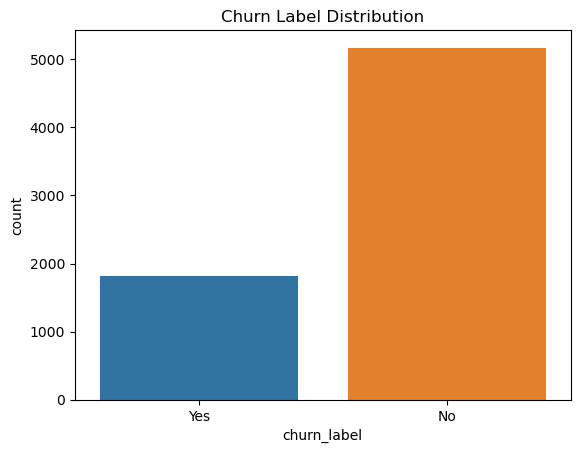

In [10]:
# from here onwards, we create charts to look at the relationship between the columns
# first I created a new column, churn_rate based on info from churn_label, in order to have a numerical churn_label

train_df['churn_rate'] = train_df['churn_label'].apply(lambda x: 1 if x == 'Yes' else 0)

# Count plot of 'churn_label'
sns.countplot(data=train_df, x='churn_label')
plt.title('Churn Label Distribution')
plt.show()

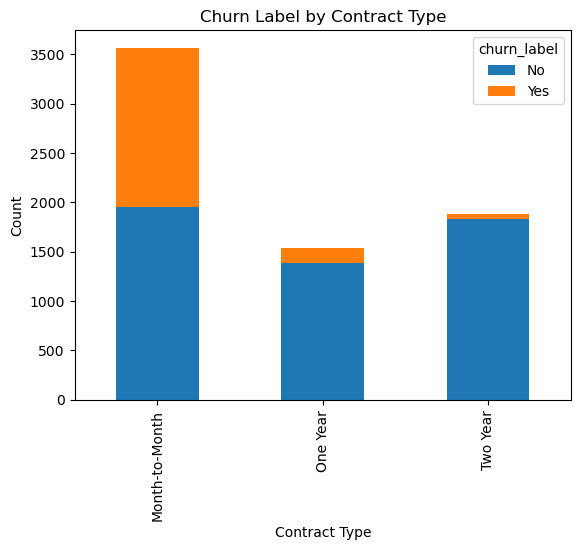

In [11]:
#    relationship between contract type and churn label
crosstab = pd.crosstab(train_df['contract_type'], train_df['churn_label'])
crosstab.plot(kind='bar', stacked=True)
plt.title('Churn Label by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Count')
plt.show()

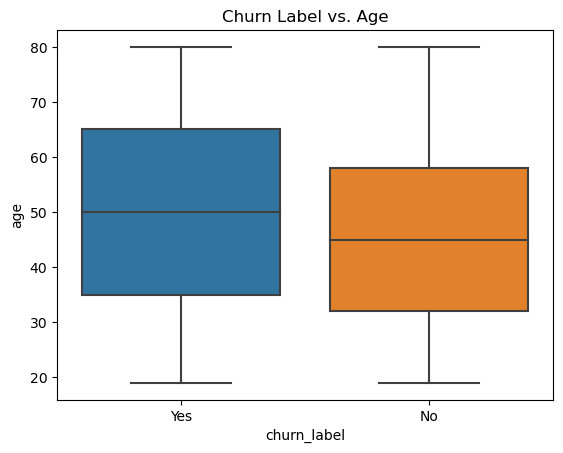

In [12]:
#relationship between age and churn rate
sns.boxplot(data=train_df, x='churn_label', y='age')
plt.title('Churn Label vs. Age')
plt.show()

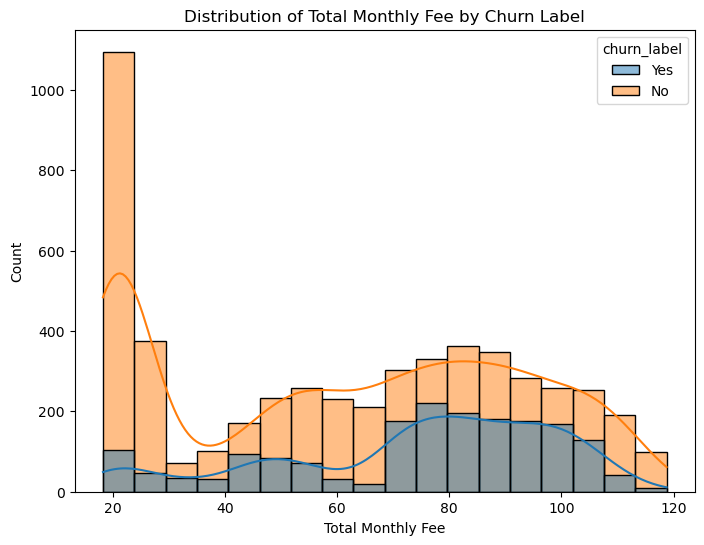

In [13]:
#relationship between monthly fee and churn rate

plt.figure(figsize=(8, 6))
sns.histplot(data=train_df, x='total_monthly_fee', hue='churn_label', kde=True)
plt.title('Distribution of Total Monthly Fee by Churn Label')
plt.xlabel('Total Monthly Fee')
plt.show()

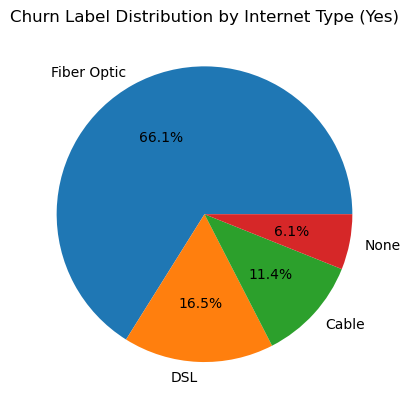

In [14]:
#relationship between internet type and churn rate

internet_type_counts = train_df[train_df['churn_label'] == 'Yes']['internet_type'].value_counts()
plt.pie(internet_type_counts, labels=internet_type_counts.index, autopct='%1.1f%%')
plt.title('Churn Label Distribution by Internet Type (Yes)')
plt.show()

C:\Users\matri\AppData\Local\Temp\ipykernel_22200\3733788476.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = train_df.corr()


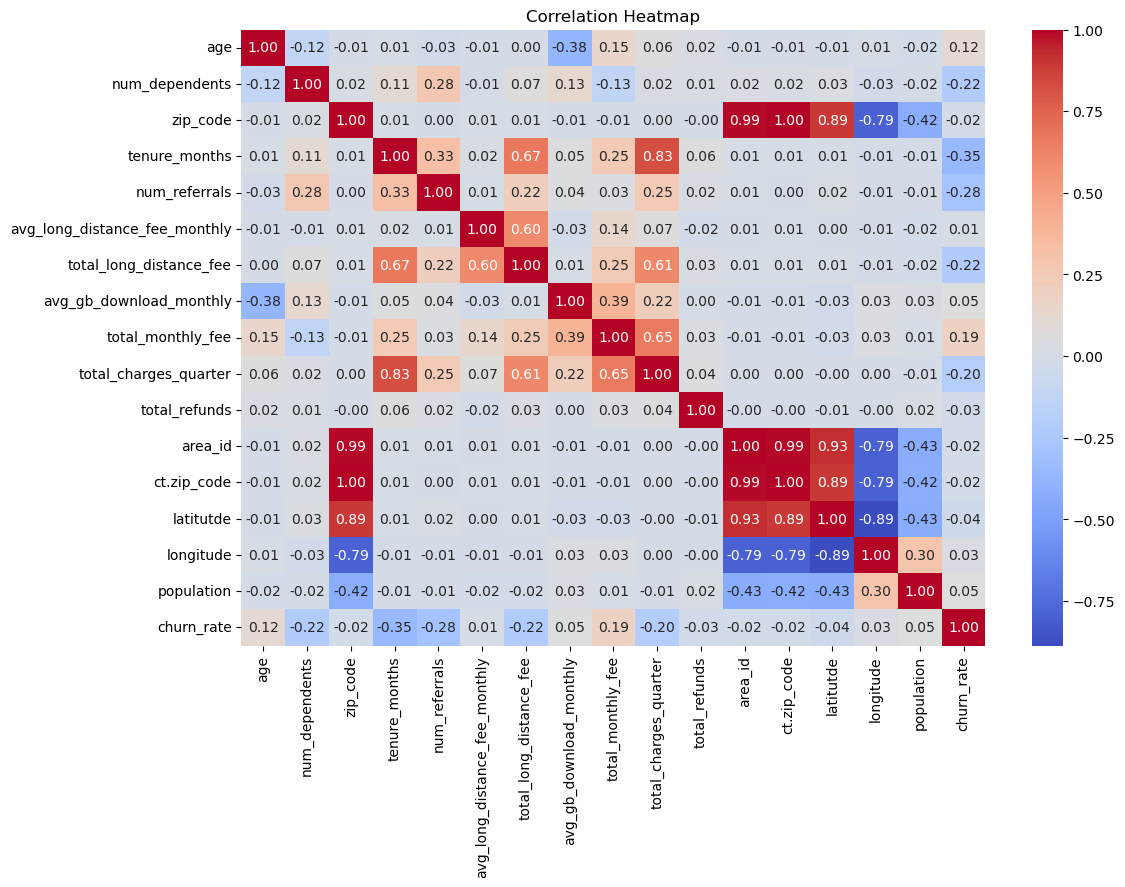

In [15]:

correlation_matrix = train_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

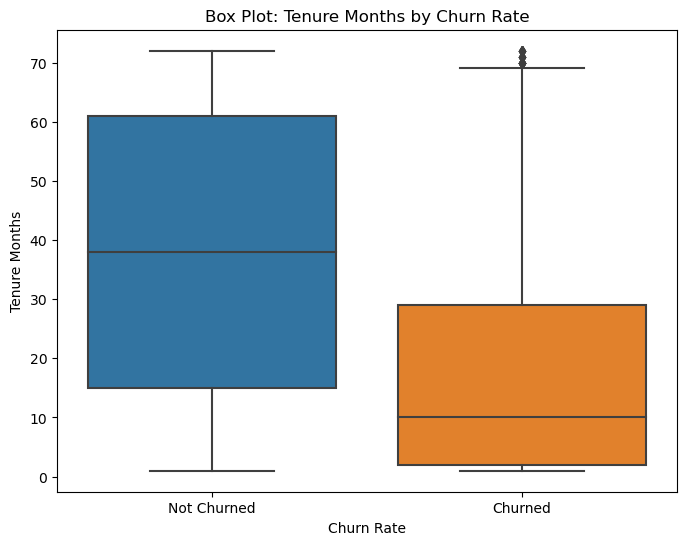

In [16]:
# Box plot of 'tenure_months' grouped by 'churn_rate'
plt.figure(figsize=(8, 6))
sns.boxplot(data=train_df, x='churn_rate', y='tenure_months')
plt.title('Box Plot: Tenure Months by Churn Rate')
plt.xticks([0, 1], ['Not Churned', 'Churned'])
plt.xlabel('Churn Rate')
plt.ylabel('Tenure Months')
plt.show()

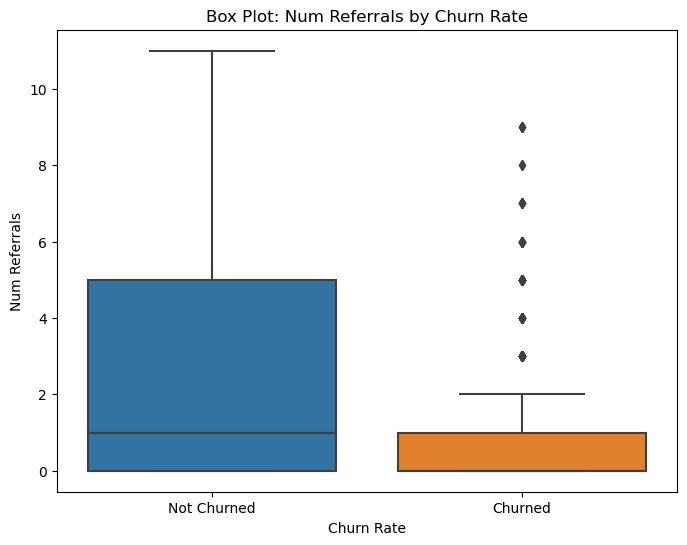

In [17]:
# Box plot of 'num_referrals' grouped by 'churn_rate'
plt.figure(figsize=(8, 6))
sns.boxplot(data=train_df, x='churn_rate', y='num_referrals')
plt.title('Box Plot: Num Referrals by Churn Rate')
plt.xticks([0, 1], ['Not Churned', 'Churned'])
plt.xlabel('Churn Rate')
plt.ylabel('Num Referrals')
plt.show()

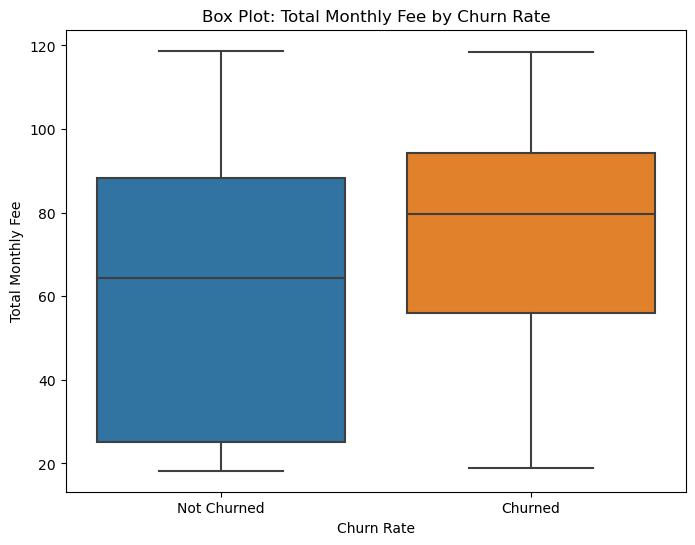

In [18]:
# Box plot of 'total_monthly_fee' grouped by 'churn_rate'
plt.figure(figsize=(8, 6))
sns.boxplot(data=train_df, x='churn_rate', y='total_monthly_fee')
plt.title('Box Plot: Total Monthly Fee by Churn Rate')
plt.xticks([0, 1], ['Not Churned', 'Churned'])
plt.xlabel('Churn Rate')
plt.ylabel('Total Monthly Fee')
plt.show()

In [19]:
#feature engineering starts here
#1st to create the numerical column for contract type
contract_mapping = {
    'One Year': 12,
    'Month-to-Month': 1,
    'Two Year': 24
}
train_df['contract'] = train_df['contract_type'].map(contract_mapping)


C:\Users\matri\AppData\Local\Temp\ipykernel_22200\2714634907.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['contract'] = train_df['contract_type'].map(contract_mapping)


In [20]:
#2nd to create the numerical column for various "yes" "no" fields

train_df['premium_tech'] = train_df['has_premium_tech_support'].apply(lambda x: 1 if x == 'Yes' else 0)
train_df['security'] = train_df['has_online_security'].apply(lambda x: 1 if x == 'Yes' else 0)
train_df['internet'] = train_df['has_internet_service'].apply(lambda x: 1 if x == 'Yes' else 0)


payment_mapping = {
    'Credit Card': 1,
    'Bank Withdrawal': 2,
    'Mailed Check': 3
}
train_df['paymentmethod'] = train_df['payment_method'].map(payment_mapping)


C:\Users\matri\AppData\Local\Temp\ipykernel_22200\1127628550.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['premium_tech'] = train_df['has_premium_tech_support'].apply(lambda x: 1 if x == 'Yes' else 0)
C:\Users\matri\AppData\Local\Temp\ipykernel_22200\1127628550.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['security'] = train_df['has_online_security'].apply(lambda x: 1 if x == 'Yes' else 0)
C:\Users\matri\AppData\Local\Temp\ipykernel_22200\1127628550.py:5: SettingWithCopyWarni

In [21]:
#specify features to train
features = ['contract','total_monthly_fee','tenure_months','num_referrals','premium_tech', 'security', 'internet', 'paymentmethod']
X = train_df[features] # Select the features you want to use to predict the loan_status
y = train_df['churn_rate']

In [27]:
#first model xgboost

import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn import metrics
import statistics

kf = KFold(n_splits=10)

model= xgb.XGBClassifier(eta=0.3, n_estimators = 50, random_state = 5, max_depth=6)

k_fold_auc = []

for train_index, test_index in kf.split(X):
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    train_model = model.fit(X_train, y_train)
    y_proba = train_model.predict_proba(X_test)[:,1]
    
    auc = metrics.roc_auc_score(y_test, y_proba)
    k_fold_auc.append(auc)

print('The Average AUC is:', statistics.mean(k_fold_auc))

The Average AUC is: 0.8858443155977551


In [23]:
#second model decision tree

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn import metrics
import statistics

kf = KFold(n_splits=10)

# Modify the model to use Decision Tree Classifier
model = DecisionTreeClassifier(random_state=5, max_depth=6)

k_fold_auc = []

for train_index, test_index in kf.split(X):
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    train_model = model.fit(X_train, y_train)
    y_proba = train_model.predict_proba(X_test)[:,1]
    
    auc = metrics.roc_auc_score(y_test, y_proba)
    k_fold_auc.append(auc)

print('The Average AUC is:', statistics.mean(k_fold_auc))

The Average AUC is: 0.8701570986974864


In [24]:
#third model random forest classifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn import metrics
import statistics

kf = KFold(n_splits=10)

# Modify the model to use Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=5, max_depth=6)

k_fold_auc = []

for train_index, test_index in kf.split(X):
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    train_model = model.fit(X_train, y_train)
    y_proba = train_model.predict_proba(X_test)[:, 1]
    
    auc = metrics.roc_auc_score(y_test, y_proba)
    k_fold_auc.append(auc)

print('The Average AUC is:', statistics.mean(k_fold_auc))

The Average AUC is: 0.886842877016129


In [28]:
#performing parameter tuning

from sklearn.model_selection import GridSearchCV

# Define a grid of hyperparameters to search
param_grid = {
    'eta': [0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 150],
    'max_depth': [4, 6, 8]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=kf)

# Perform the grid search
grid_search.fit(X, y)

# Get the best hyperparameters
best_params = grid_search.best_params_

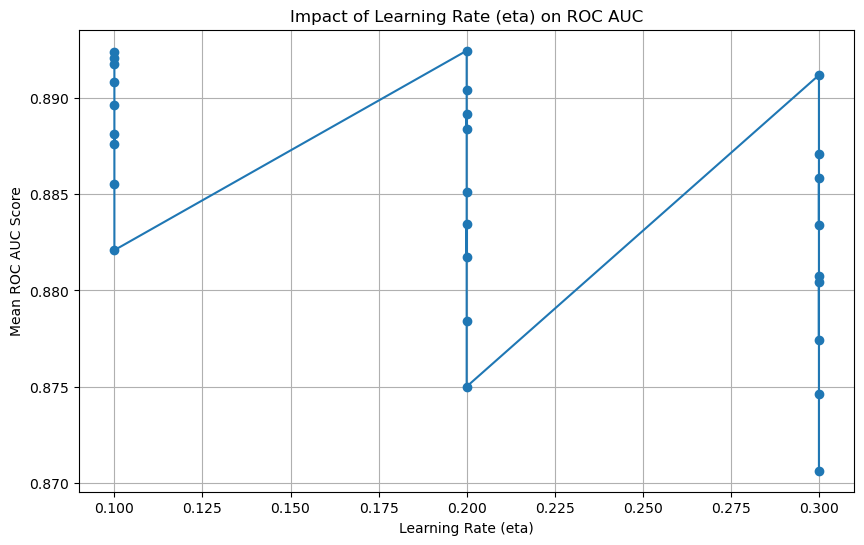

In [29]:
#visualising parameter tuning result

import matplotlib.pyplot as plt


# Extract the values of 'eta' and corresponding mean test scores (ROC AUC)
etas = [params['eta'] for params in grid_search.cv_results_['params']]
mean_test_scores = grid_search.cv_results_['mean_test_score']

# Create a plot to visualize the impact of 'eta' on ROC AUC
plt.figure(figsize=(10, 6))
plt.plot(etas, mean_test_scores, marker='o', linestyle='-')
plt.title('Impact of Learning Rate (eta) on ROC AUC')
plt.xlabel('Learning Rate (eta)')
plt.ylabel('Mean ROC AUC Score')
plt.grid(True)
plt.show()

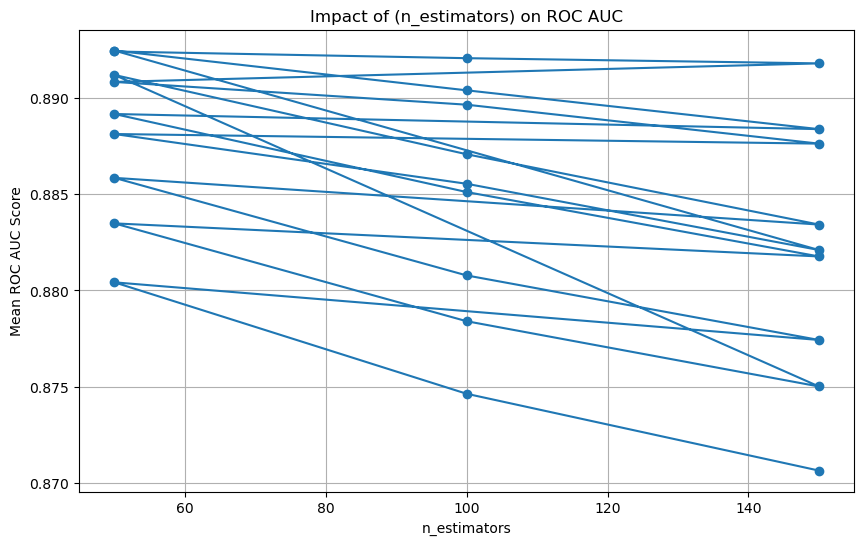

In [30]:
import matplotlib.pyplot as plt


# Extract the values of 'eta' and corresponding mean test scores (ROC AUC)
etas = [params['n_estimators'] for params in grid_search.cv_results_['params']]
mean_test_scores = grid_search.cv_results_['mean_test_score']

# Create a plot to visualize the impact of 'eta' on ROC AUC
plt.figure(figsize=(10, 6))
plt.plot(etas, mean_test_scores, marker='o', linestyle='-')
plt.title('Impact of (n_estimators) on ROC AUC')
plt.xlabel('n_estimators')
plt.ylabel('Mean ROC AUC Score')
plt.grid(True)
plt.show()

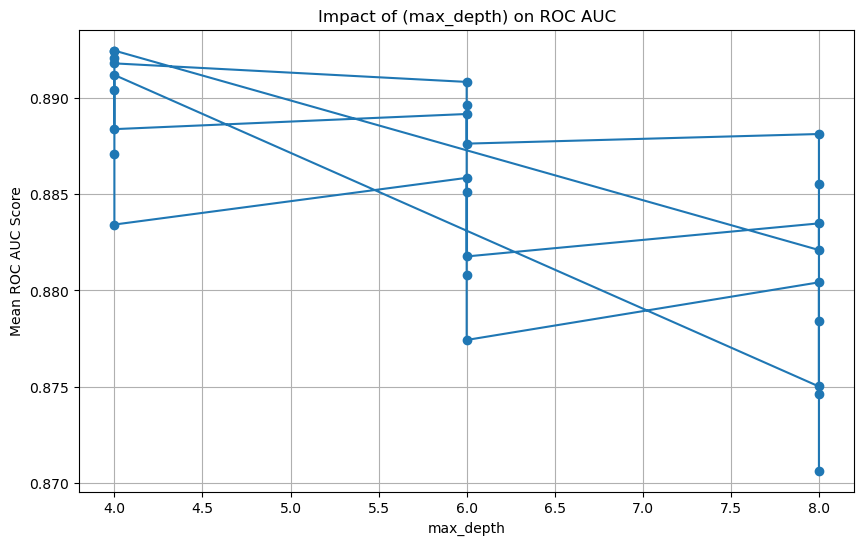

In [31]:
import matplotlib.pyplot as plt


# Extract the values of 'eta' and corresponding mean test scores (ROC AUC)
etas = [params['max_depth'] for params in grid_search.cv_results_['params']]
mean_test_scores = grid_search.cv_results_['mean_test_score']

# Create a plot to visualize the impact of 'eta' on ROC AUC
plt.figure(figsize=(10, 6))
plt.plot(etas, mean_test_scores, marker='o', linestyle='-')
plt.title('Impact of (max_depth) on ROC AUC')
plt.xlabel('max_depth')
plt.ylabel('Mean ROC AUC Score')
plt.grid(True)
plt.show()

In [32]:
#rerun xgboost using optimised parameter

# Extract the best hyperparameters
best_eta = best_params['eta']
best_n_estimators = best_params['n_estimators']
best_max_depth = best_params['max_depth']

kf = KFold(n_splits=10)

best_model= xgb.XGBClassifier(eta=best_eta, n_estimators = best_n_estimators, random_state = 5, max_depth=best_max_depth)

k_fold_auc = []

for train_index, test_index in kf.split(X):
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    train_model = model.fit(X_train, y_train)
    y_proba = train_model.predict_proba(X_test)[:,1]
    
    auc = metrics.roc_auc_score(y_test, y_proba)
    k_fold_auc.append(auc)

print('The Average AUC is:', statistics.mean(k_fold_auc))

The Average AUC is: 0.8858443155977551


In [33]:
#dump the model into .pkl file using joblib

import joblib
joblib.dump(best_model, 'xgb_model.pkl')

['xgb_model.pkl']